# Imports

In [1]:
import os
import pickle
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [3]:
from dataset.utils import load_coco, load_image, print_progress_bar
from topic_extraction.topic_layers import load_topic_model, load_feature_model

# Load Data

In [4]:
# Folder containing the datset
data_dir = 'dataset/'

In [5]:
train_data, val_data, test_data, category_id, id_category = load_coco(
    os.path.join(data_dir, 'coco_raw.pickle'), 'captions', 
)

In [6]:
train_images, train_captions = train_data  # Load training data
val_images, val_captions = val_data  # Load validation data
test_images, test_captions = test_data  # Load test data

In [7]:
num_classes = len(id_category)
num_classes

80

In [8]:
num_images_train = len(train_images)
num_images_train

19324

### Display a sample image

A group of skiers stand near a lodge at a snow resort.
A group of people on skis in the snow.
A man standing on skis while others stand around watching.
A skier is getting ready while onlookers watch
A man on skis being watched by some younger people.


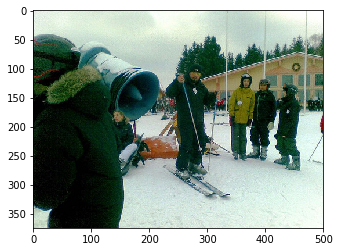

In [9]:
# display image
idx = 10

for caption in train_captions[idx]:
    print(caption)

plt.imshow(load_image(os.path.join(data_dir, train_images[idx])))
plt.show()

# Pre-Trained Topic Model

In [10]:
# Load the pre-trained topic model
weights_path = os.path.join(os.getcwd(), 'topic_extraction', 'weights', 'checkpoint.keras')
topic_model = load_topic_model(num_classes, weights_path)
topic_model.summary()

Weights loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 4096)              139570240 
_________________________________________________________________
dense (Dense)                (None, 80)                327760    
Total params: 139,898,000
Trainable params: 327,760
Non-trainable params: 139,570,240
_________________________________________________________________


In [11]:
# Load the pre-trained feature extractor model
feature_model = load_feature_model()

### Process Images

In [12]:
def process_images(topic_model, feature_model, data_dir, filenames, batch_size):
    """
    Process all the given files in the given data_dir using the
    pre-trained topic-model as well as the feature-model and return
    their transfer-values.
    
    The images are processed in batches to save
    memory and improve efficiency.
    """
    
    # Number of images to process.
    num_images = len(filenames)
    
    # Get the expected input size of the pre-trained network
    img_size = K.int_shape(topic_model.input)[1:3]

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float32)

    # Pre-allocate output-array for transfer-values.
    topic_transfer_values = np.zeros(
        shape=(num_images,) + K.int_shape(topic_model.output)[1:],
        dtype=np.int
    )
    feature_transfer_values = np.zeros(
        shape=(num_images, K.int_shape(feature_model.output)[1]),
        dtype=np.float32
    )

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress_bar(start_index, num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)
            
            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained models to process the image.
        topic_predictions = topic_model.predict(
            image_batch[0:current_batch_size]
        )
        topic_transfer_values_batch = (topic_predictions > 0.5).astype('int')
        
        feature_transfer_values_batch = feature_model.predict(
            image_batch[0:current_batch_size]
        )

        # Save the transfer-values in the pre-allocated arrays.
        topic_transfer_values[start_index:end_index] = topic_transfer_values_batch[0:current_batch_size]
        feature_transfer_values[start_index:end_index] = feature_transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return topic_transfer_values, feature_transfer_values

In [13]:
def process_data(topic_model, feature_model, data_dir, data_type, filenames, captions, batch_size):
    print('Processing {0} images in training-set ...'.format(len(filenames)))

    # Path for the cache-file.
    cache_path_dir = os.path.join(data_dir, 'processed_caption_data')
    topic_cache_path = os.path.join(
        cache_path_dir, 'topic_transfer_values_{}.pkl'.format(data_type)
    )
    feature_cache_path = os.path.join(
        cache_path_dir, 'feature_transfer_values_{}.pkl'.format(data_type)
    )
    captions_cache_path = os.path.join(
        cache_path_dir, 'captions_{}.pkl'.format(data_type)
    )
    
    # Check if directory to store processed data exists
    if os.path.exists(cache_path_dir):
        print('Directory created:', cache_path_dir)
        os.mkdir(cache_path_dir)

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    if os.path.exists(topic_cache_path) and os.path.exists(feature_cache_path) and os.path.exists(captions_cache_path):
        with open(topic_cache_path, mode='rb') as file:
            topic_obj = pickle.load(file)
        with open(feature_cache_path, mode='rb') as file:
            feature_obj = pickle.load(file)
        with open(captions_cache_path, mode='rb') as file:
            captions = pickle.load(file)
        print("Data loaded from cache-file.")
    else:
        topic_obj, feature_obj = process_images(
            topic_model, feature_model, data_dir, filenames, batch_size
        )
        with open(topic_cache_path, mode='wb') as file:
            pickle.dump(topic_obj, file)
        with open(feature_cache_path, mode='wb') as file:
            pickle.dump(feature_obj, file)
        with open(captions_cache_path, mode='wb') as file:
            pickle.dump(captions, file)
        print("Data saved to cache-file.")

    return topic_obj, feature_obj, captions

In [14]:
process_batch_size = 64

In [ ]:
%%time
topic_transfer_values_train, feature_transfer_values_train, captions_train = process_data(
    topic_model, feature_model, data_dir, 'train', train_images, train_captions, process_batch_size
)
print("topic shape:", topic_transfer_values_train.shape)
print("feature shape:", feature_transfer_values_train.shape)

Processing 19324 images in training-set ...


In [ ]:
%%time
topic_transfer_values_val, feature_transfer_values_val, captions_val = process_data(
    topic_model, feature_model, data_dir, 'val', val_images, val_captions, process_batch_size
)
print("topic shape:", topic_transfer_values_val.shape)
print("feature shape:", feature_transfer_values_val.shape)

# Tokenizer

In [ ]:
mark_start = 'ssss '
mark_end = ' eeee'

In [ ]:
def mark_captions(captions_list):
    """ Mark all the captions with the start and the end marker """
    captions_marked = [
        [mark_start + caption + mark_end for caption in captions] for captions in captions_list
    ]
    
    return captions_marked

In [ ]:
captions_train_marked = mark_captions(captions_train)
print('Marked captions:')
captions_train_marked[0]

In [ ]:
print('\nOriginal captions:')
captions_train[0]

In [ ]:
def flatten(captions_list):
    """ Flatten all the captions into a single list """
    caption_list = [caption
                    for caption_list in captions_list
                    for caption in caption_list]
    
    return caption_list

In [ ]:
captions_train_flat = flatten(captions_train_marked)

In [ ]:
# Maximum number of most-frequent words to be considered from the training data
num_words = 10000

In [ ]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(
            self.word_index.values(), self.word_index.keys()
        ))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token] for token in tokens if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_list):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(caption_list) for caption_list in captions_list]
        
        return tokens

Create the tokenizer

In [ ]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat, num_words=num_words)

In [ ]:
# Get integer token for the start marker
token_start = tokenizer.word_index[mark_start.strip()]
token_start

In [ ]:
# Get integer token for the end marker
token_end = tokenizer.word_index[mark_end.strip()]
token_end

Convert all the captions from the training-set to sequence of integer tokens.

In [ ]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

In [ ]:
print('Token sequences for the first image in the training-set:')
tokens_train[0]

In [ ]:
print('\nCorresponding captions:')
captions_train_marked[0]

# Data Generator

Each image in the training-set has at least 5 captions describing the contents of the image. The neural network will be trained with batches of transfer-values for the images and sequences of integer-tokens for the captions. If we were to have matching numpy arrays for the training-set, we would either have to only use a single caption for each image and ignore the rest of this valuable data, or we would have to repeat the image transfer-values for each of the captions, which would waste a lot of memory.

A better solution is to create a custom data-generator for Keras that will create a batch of data with randomly selected transfer-values and token-sequences.

This helper-function returns a list of random token-sequences for the images with the given indices in the training-set.

In [ ]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

In [ ]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train, size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(
            tokens,
            maxlen=max_tokens,
            padding='post',
            truncating='post'
        )
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [ ]:
batch_size = 128
generator = batch_generator(batch_size=batch_size)
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [ ]:
# Example of the transfer-values for the first image in the batch
batch_x['transfer_values_input'][0]

In [ ]:
# Example of the token-sequence for the first image in the batch
# This is the input to the decoder-part of the neural network
batch_x['decoder_input'][0]

In [ ]:
# This is the token-sequence for the output of the decoder
# Note how it is the same as the sequence above, except it is shifted one time-step
batch_y['decoder_output'][0]

## Steps Per Epoch

One epoch is a complete processing of the training-set. We would like to process each image and caption pair only once per epoch. However, because each batch is chosen completely at random in the above batch-generator, it is possible that an image occurs in multiple batches within a single epoch, and it is possible that some images may not occur in any batch at all within a single epoch.

Nevertheless, we still use the concept of an 'epoch' to measure approximately how many iterations of the training-data we have processed. But the data-generator will generate batches for eternity, so we need to manually calculate the approximate number of batches required per epoch.

In [ ]:
# Number of captions for each image in the training-set
num_captions_train = [len(captions) for captions in captions_train]

# Total number of captions in the training-set
total_num_captions_train = np.sum(num_captions_train)

# Approximate number of batches required per epoch,
# if we want to process each caption and image pair once per epoch
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

# Recurrent Neural Network

## Embedding Layer

In [ ]:
def read_glove_vecs(glove_file):
    print('Creating word to vec map...')
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float32)
    print('Done!')
    return word_to_vec_map

In [ ]:
# load embeddings
word_to_vec_map = read_glove_vecs('{}/glove.6B.100d.txt'.format(data_dir))

In [ ]:
# assign embeddings values to custom tokens
size = word_to_vec_map['unk'].shape

word_to_vec_map[mark_start.strip()] = np.random.uniform(low=-1.0, high=1.0, size=size)
word_to_vec_map[mark_end.strip()] = np.random.uniform(low=-1.0, high=1.0, size=size)

In [ ]:
def create_embedding_layer(word_to_index, word_to_vec_map, num_words):
    """ Create a Keras Embedding() layer and load in pre-trained GloVe 100-dimensional vectors
        @params:
        :word_to_index -- dictionary containing the each word mapped to its index
        :word_to_vec_map -- dictionary mapping words to their GloVe vector representation
        :num_words -- number of words in the vocabulary
        
        @return:
        :decoder_embedding -- pretrained layer Keras instance
    """
    
    vocabulary_length = num_words + 1  # adding 1 to fit Keras embedding (requirement)
    embedding_dimensions = word_to_vec_map['unk'].shape[0]  # define dimensionality of GloVe word vectors (= 100)
    
    embedding_matrix = np.zeros((vocabulary_length, embedding_dimensions))  # initialize with zeros
    for word, index in word_to_index.items():
        try:
            embedding_matrix[index, :] = word_to_vec_map[word]
        except KeyError:
            embedding_matrix[index, :] = word_to_vec_map['unk']
    
    # we don't want the embeddings to be updated, thus trainable parameter is set to False
    decoder_embedding = Embedding(
        input_dim=vocabulary_length,
        output_dim=embedding_dimensions,
        trainable=False,
        name='decoder_embedding'
    )
    decoder_embedding.build((None,))
    decoder_embedding.set_weights([embedding_matrix])  # with this the layer is now pretrained
    
    return decoder_embedding

## Create RNN

In [ ]:
# Internal state-sizes of GRUs
state_size = 512

In [ ]:
# This inputs transfer-values to the decoder
transfer_values_input = Input(shape=(transfer_values_size,), name='transfer_values_input')

The transfer-values are used to initialize the internal states of the GRU units. This informs the GRU units of the contents of the images. The transfer-values are vectors of length 4096 but the size of the internal states of the GRU units are only 512, so fully-connected layer is used to map the vectors from 4096 to 512 elements.

In [ ]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [ ]:
# Input for token-sequences to the decoder
# Using 'None' in the shape means that the token-sequences can have arbitrary lengths
decoder_input = Input(shape=(None, ), name='decoder_input')

In [ ]:
# Embedding-layer which converts sequences of integer-tokens to sequences of vectors
decoder_embedding = create_embedding_layer(tokenizer.word_index, word_to_vec_map, num_words)

In [ ]:
# The 3 GRU layers of the decoder
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

The GRU layers output a tensor with shape `[batch_size, sequence_length, state_size]`, where each "word" is encoded as a vector of length `state_size`. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

Note that the activation-function is set to `linear` instead of `softmax` as we would normally use for one-hot encoded outputs, because there is apparently a bug in Keras so we need to make our own loss-function, as described in detail further below.

In [ ]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

### Attention Mechanism

In [ ]:
# TODO: Add attention

# Connect and Create the Training Model

In [ ]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [ ]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(
    inputs=[transfer_values_input, decoder_input],
    outputs=[decoder_output]
)

In [ ]:
decoder_model.summary()

### Loss Function

In [ ]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

## Compile the Training Model

In [ ]:
optimizer = RMSprop(lr=1e-3)

There seems to be a bug in Keras that it cannot automatically deduce the correct shape of the decoder's output data. We therefore need to manually create a placeholder variable for the decoder's output. The shape is set to `(None, None)` which means the batch can have an arbitrary number of sequences, which can have an arbitrary number of integer-tokens.

In [ ]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [ ]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

### Callback Functions

In [ ]:
path_checkpoint = 'checkpoint_new.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint

In [ ]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

### Train the Model

In [ ]:
%%time
decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=20,
                            callbacks=callbacks)

# Generate Captions

In [ ]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

In [ ]:
generate_caption('dataset/' + filenames_val[120])

### Generate both true and predicted labels

In [ ]:
def generate_caption_coco(idx, train=False):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    generate_caption(image_path=path)

    # Print the true captions from the data-set.
    print("True captions:")
    for caption in captions:
        print(caption)

In [ ]:
generate_caption_coco(idx=1, train=False)